<a href="https://colab.research.google.com/github/cksdnr1/PyTorchPJ/blob/main/2_1_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 변수의 shape, type, value 확인
def p(var,_str='') :
    if _str=='\n' or _str=='cr' :
        _str = '\n'
    else :
        print(f'<<{_str}>>:')
        _str = ''
    if type(var)!=type([]):
        try: 
            print(f'Shape:{var.shape}')
        except : 
            pass
    print(f'Type: {type(var)}')
    print(f'Values: {var}'+_str)

def pst(_x,_name=""):
    print(f'[{_name}] Shape{_x.shape}, {type(_x)}')
def ps(_x,_name=""):
    print(f'[{_name}] Shape{_x.shape}') 

# Model 설계 workfolw

In [ ]:
%%capture
!pip install pytorch_lightning torchinfo torchmetrics torchviz

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
import torch.optim as optim

import pytorch_lightning as pl
from pytorch_lightning.accelerators import accelerator
from torchmetrics import functional as FM
from torchinfo import summary

from torchvision.datasets import MNIST
import torchvision.transforms as transforms
import torch.utils.data as data 
from torch.utils.data import DataLoader

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

torch.__version__,pl.__version__,

('1.12.1+cu113', '1.8.3.post1')

## 1. 첫번째 모델 만들기

### Dataset 준비

###  Model 정의

In [ ]:
loss_function = nn.CrossEntropyLoss()
class FirstModel(pl.LightningModule):
    def __init__(self):
        super(FirstModel, self).__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 10) )
    def forward(self, x):
        out = self.layers(x)
        return out
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x) 
        loss = loss_function(y_pred, y)
        acc = FM.accuracy(y_pred, y)
        self.log_dict({'loss':loss, 'acc':acc})
        return loss
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x) 
        loss = loss_function(y_pred, y)
        acc = FM.accuracy(y_pred, y)
        self.log_dict({'val_loss':loss, 'val_acc':acc})
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

In [ ]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

def dataLoader(batch_size=128):
    train_dataset = MNIST('', transform=transforms.ToTensor(), train=True, download=True)
    test_dataset = MNIST('', transform=transforms.ToTensor(), train=False, download=True)
    trainDataLoader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valDataLoader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return (trainDataLoader,valDataLoader)

trainDataLoader,valDataLoader = dataLoader()

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting MNIST/raw/train-images-idx3-ubyte.gz to MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/raw



* Model 생성, Summary보기 

In [ ]:
model = FirstModel()
summary(model, input_size=(128, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
FirstModel                               [128, 10]                 --
├─Sequential: 1-1                        [128, 10]                 --
│    └─Flatten: 2-1                      [128, 784]                --
│    └─Linear: 2-2                       [128, 10]                 7,850
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
Total mult-adds (M): 1.00
Input size (MB): 0.40
Forward/backward pass size (MB): 0.01
Params size (MB): 0.03
Estimated Total Size (MB): 0.44

### Training, History logging 

In [ ]:
%%time
epochs = 1
logger = pl.loggers.CSVLogger("logs", name="firstModel")
trainer = pl.Trainer(max_epochs=epochs, logger=logger, accelerator="auto")
trainer.fit(model, trainDataLoader, valDataLoader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 7.9 K 
--------------------------------------
7.9 K     Trainable params
0         Non-trainable params
7.9 K     Total params
0.031     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


CPU times: user 11.5 s, sys: 428 ms, total: 12 s
Wall time: 12.3 s


* Log data 보기 

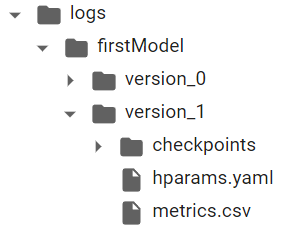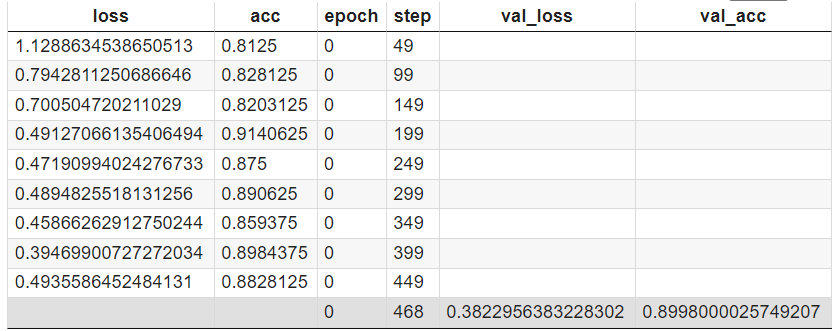

### Test 

In [ ]:
test_batch = next(iter(valDataLoader))  #(128,1,28,28),(128,10) <- 
preds = model(test_batch[0])            #(128,10) <- ((128,1,28,28),(128,))
p(preds[0],'preds'),print()                     # Class logits (10,)
p(torch.softmax(preds[0],dim=0),'softmax'),print()# Class Prob.  (10,) 
p(np.argmax(torch.softmax(preds[0],dim=0).detach()),'index') # Class idx 

<<preds>>:
Shape:torch.Size([10])
Type: <class 'torch.Tensor'>
Values: tensor([-1.7024, -8.5125, -1.9879,  1.4538, -3.4946, -1.9000, -7.8205,  7.3334,
        -1.6583,  1.4557], grad_fn=<SelectBackward0>)

<<softmax>>:
Shape:torch.Size([10])
Type: <class 'torch.Tensor'>
Values: tensor([1.1836e-04, 1.3050e-07, 8.8958e-05, 2.7790e-03, 1.9718e-05, 9.7139e-05,
        2.6070e-07, 9.9399e-01, 1.2370e-04, 2.7845e-03],
       grad_fn=<SoftmaxBackward0>)

<<index>>:
Shape:torch.Size([])
Type: <class 'torch.Tensor'>
Values: 7


* History file read

In [ ]:
v_num = logger.version  
history = pd.read_csv(f'./logs/firstModel/version_{v_num}/metrics.csv')
history.groupby('epoch').last().drop('step', axis=1)

,loss,acc,val_loss,val_acc
epoch,,,,
0,0.358264,0.867188,0.304976,0.9154


In [ ]:
history

,loss,acc,epoch,step,val_loss,val_acc
0,0.309012,0.929688,0,49,NaN,NaN
1,0.501885,0.851562,0,99,NaN,NaN
2,0.440810,0.906250,0,149,NaN,NaN
3,0.391920,0.875000,0,199,NaN,NaN
4,0.419993,0.882812,0,249,NaN,NaN
5,0.262686,0.937500,0,299,NaN,NaN
6,0.328890,0.890625,0,349,NaN,NaN
7,0.405128,0.906250,0,399,NaN,NaN
8,0.358264,0.867188,0,449,NaN,NaN
9,NaN,NaN,0,468,0.304976,0.9154


## 2. 모듈을 만드는 방법

### 1 Module container 사용 

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Model(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(5, 10)
        self.linear2 = nn.Linear(10,1)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        return x

model = Model()
summary(model, input_size=(8, 5))

Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [8, 1]                    --
├─Linear: 1-1                            [8, 10]                   60
├─Linear: 1-2                            [8, 1]                    11
Total params: 71
Trainable params: 71
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

**+ class** 

In [ ]:
class MyModel(pl.LightningModule):
    def __init__(self):
        super(MyModel, self).__init__()
        self.layers =  Model()
    
    def forward(self, x):
        out = self.layers(x)
        return out
model = MyModel()
summary(model, input_size=(8, 5))

Layer (type:depth-idx)                   Output Shape              Param #
MyModel                                  [8, 1]                    --
├─Model: 1-1                             [8, 1]                    --
│    └─Linear: 2-1                       [8, 10]                   60
│    └─Linear: 2-2                       [8, 1]                    11
Total params: 71
Trainable params: 71
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

In [ ]:
p(model,'model')
p(model.layers,'model.layers')
p(model.layers.linear1,'model.layers.linear1'),print()
p(model.layers.children,'model.layers.children')

<<model>>:
Type: <class '__main__.MyModel'>
Values: MyModel(
  (layers): Model(
    (linear1): Linear(in_features=5, out_features=10, bias=True)
    (linear2): Linear(in_features=10, out_features=1, bias=True)
  )
)
<<model.layers>>:
Type: <class '__main__.Model'>
Values: Model(
  (linear1): Linear(in_features=5, out_features=10, bias=True)
  (linear2): Linear(in_features=10, out_features=1, bias=True)
)
<<model.layers.linear1>>:
Type: <class 'torch.nn.modules.linear.Linear'>
Values: Linear(in_features=5, out_features=10, bias=True)

<<model.layers.children>>:
Type: <class 'method'>
Values: <bound method Module.children of Model(
  (linear1): Linear(in_features=5, out_features=10, bias=True)
  (linear2): Linear(in_features=10, out_features=1, bias=True)
)>


### 2.1 Sequential container : Type 1

 - argument로 module을 전달



In [ ]:
loss_function = nn.CrossEntropyLoss()
class Model(pl.LightningModule):
    def __init__(self):
        super(Model, self).__init__()
        self.layers =  nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 64),
            nn.Linear(64,10) 
            )  
    def forward(self, x):
        out = self.layers(x)
        return out

model = Model()
summary(model, input_size=(8, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [8, 10]                   --
├─Sequential: 1-1                        [8, 10]                   --
│    └─Flatten: 2-1                      [8, 784]                  --
│    └─Linear: 2-2                       [8, 64]                   50,240
│    └─Linear: 2-3                       [8, 10]                   650
Total params: 50,890
Trainable params: 50,890
Non-trainable params: 0
Total mult-adds (M): 0.41
Input size (MB): 0.03
Forward/backward pass size (MB): 0.00
Params size (MB): 0.20
Estimated Total Size (MB): 0.23

### 2.2 Sequential + add_module(): Type 2

In [ ]:
class Model(pl.LightningModule):
    def __init__(self):
        super(Model, self).__init__()
        self.layers = nn.Sequential()
        self.layers.add_module('linear1', nn.Linear(28*28, 64))
        self.layers.add_module('linear2', nn.Linear(64,10))
    
    def forward(self, x):
        out = self.layers(x)
        return out

model = Model()
summary(model, input_size=(8, 1, 28*28))

Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [8, 1, 10]                --
├─Sequential: 1-1                        [8, 1, 10]                --
│    └─Linear: 2-1                       [8, 1, 64]                50,240
│    └─Linear: 2-2                       [8, 1, 10]                650
Total params: 50,890
Trainable params: 50,890
Non-trainable params: 0
Total mult-adds (M): 0.41
Input size (MB): 0.03
Forward/backward pass size (MB): 0.00
Params size (MB): 0.20
Estimated Total Size (MB): 0.23

### 2.3 Sequential + OrderedDict : Type 3

In [ ]:
from collections import OrderedDict
class Model(pl.LightningModule):
    def __init__(self):
        super(Model, self).__init__()
        self.layers = nn.Sequential(OrderedDict([
            ('flatten', nn.Flatten()),
            ('linear1', nn.Linear(28*28,64)),
            ('linear2', nn.Linear(64,10)),
          ]))
    def forward(self, x):
        out = self.layers(x)
        return out

model = Model()
summary(model, input_size=(8, 1, 28, 28))      

Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [8, 10]                   --
├─Sequential: 1-1                        [8, 10]                   --
│    └─Flatten: 2-1                      [8, 784]                  --
│    └─Linear: 2-2                       [8, 64]                   50,240
│    └─Linear: 2-3                       [8, 10]                   650
Total params: 50,890
Trainable params: 50,890
Non-trainable params: 0
Total mult-adds (M): 0.41
Input size (MB): 0.03
Forward/backward pass size (MB): 0.00
Params size (MB): 0.20
Estimated Total Size (MB): 0.23

### 3 ModuleList

In [ ]:
class Model(pl.LightningModule):
    def __init__(self):
        super(Model, self).__init__()
        self.linears = nn.ModuleList([nn.Linear(10, 10) for i in range(5)])

    def forward(self, x):
        # ModuleList can act as an iterable, or be indexed using ints
        for i, l in enumerate(self.linears):
            x = self.linears[i // 2](x) + l(x)  
        return x
    #0: x = l[0](x)+l[0](x)
    #1: x = l[0](x)+l[1](x)
    #2: x = l[1](x)+l[2](x)
    #3: x = l[1](x)+l[3](x)
    #4: x = l[2](x)+l[4](x)

model = Model()
summary(model, input_size=(8, 1, 10))

Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [8, 1, 10]                --
├─ModuleList: 1-1                        --                        --
│    └─Linear: 2-1                       [8, 1, 10]                110
│    └─Linear: 2-2                       [8, 1, 10]                (recursive)
│    └─Linear: 2-3                       [8, 1, 10]                (recursive)
│    └─Linear: 2-4                       [8, 1, 10]                110
│    └─Linear: 2-5                       [8, 1, 10]                (recursive)
│    └─Linear: 2-6                       [8, 1, 10]                110
│    └─Linear: 2-7                       [8, 1, 10]                (recursive)
│    └─Linear: 2-8                       [8, 1, 10]                110
│    └─Linear: 2-9                       [8, 1, 10]                (recursive)
│    └─Linear: 2-10                      [8, 1, 10]                110
Total params: 550
Trainable params:

### 4 ModuleDict

In [ ]:
class Model(pl.LightningModule):
    def __init__(self):
        super(Model, self).__init__()
        self.layers = nn.ModuleDict({
                'conv': nn.Conv2d(10, 10, 3),
                'pool': nn.MaxPool2d(2)
        })
        self.activations = nn.ModuleDict([
                ['lrelu', nn.LeakyReLU()],
                ['prelu', nn.PReLU()]
        ])

    def forward(self, x, choice, act):
        x = self.layers[choice](x)
        x = self.activations[act](x)
        return x

model = Model()

In [ ]:
p(model)

<<>>:
Type: <class '__main__.Model'>
Values: Model(
  (layers): ModuleDict(
    (conv): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (activations): ModuleDict(
    (lrelu): LeakyReLU(negative_slope=0.01)
    (prelu): PReLU(num_parameters=1)
  )
)


### 모델 시각화  

In [ ]:
class Model(pl.LightningModule):
    def __init__(self):
        super(Model, self).__init__()
        self.flatten =  nn.Flatten()
        self.linear1 = nn.Linear(28*28, 32)
        self.linear2 = nn.Linear(28*28, 32)
        self.linear3 = nn.Linear(64, 10)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.flatten(x)
        x1 = self.linear1(x)
        x1 = self.relu(x1)
        x2 = self.linear2(x)
        x2 = self.relu(x2)
        x = torch.cat([x1, x2], dim=1)
        x = self.linear3(x)
        return x

model = Model()
summary(model, input_size=(8, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [8, 10]                   --
├─Flatten: 1-1                           [8, 784]                  --
├─Linear: 1-2                            [8, 32]                   25,120
├─ReLU: 1-3                              [8, 32]                   --
├─Linear: 1-4                            [8, 32]                   25,120
├─ReLU: 1-5                              [8, 32]                   --
├─Linear: 1-6                            [8, 10]                   650
Total params: 50,890
Trainable params: 50,890
Non-trainable params: 0
Total mult-adds (M): 0.41
Input size (MB): 0.03
Forward/backward pass size (MB): 0.00
Params size (MB): 0.20
Estimated Total Size (MB): 0.23

In [ ]:
!pip install onnx 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.1 MB 30.1 MB/s 


In [ ]:
device ='cuda:0'
torch.onnx.export(model, torch.zeros((8, 1, 28, 28)).to(device), 'model.onnx')

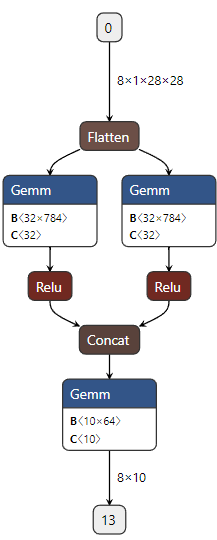

## Model = Module + methods

### training_step( )

* 내부동작의 pseudocode 
```python 
model.train() # set model.training to True 
torch.set_grad_enabled(True) # sets gradient calculation to on 
outs = []
for batch_idx, batch in enumerate(train_dataloader):
    loss = training_step(batch, batch_idx)
    outs.append(loss.detach())
    # 역전파
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
```
* PyTorch Training Loop 
```python
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # 예측(prediction)과 손실(loss) 계산
        pred = model(X)
        loss = loss_fn(pred, y)
        # 역전파
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
```

**basic code**

```python
## basic code 
def training_step(self, batch, batch_idx):
    x, y = batch
    y_hat = self(x) ## forward()
    loss = loss_function(y_hat, y)
    self.log('train_loss', loss)
    return loss

# call training process 
pl.trainer.fit(model, trainDataLoader, valDataLoader) 
```

### Training History logging 
>Logging from a LightningModule : 
https://pytorch-lightning.readthedocs.io/en/stable/extensions/logging.html 

```python
LightningModule.log(name, value, 
    prog_bar=False, logger=True, on_step=None, on_epoch=None, reduce_fx='mean', 
    enable_graph=False, sync_dist=False, sync_dist_group=None, add_dataloader_idx=True, 
    batch_size=None, metric_attribute=None, rank_zero_only=False)
```

In [ ]:
from IPython.core.display import ProgressBar
## History logging (step level)
def training_step(self, batch, batch_idx):
    x, y = batch
    y_hat = self(x)
    loss = loss_function(y_hat, y)
    self.log("loss", loss, on_step=True, on_epoch=False) 
    return loss

## History logging (epoch level)
def training_step(self, batch, batch_idx):
    x, y = batch
    y_hat = self(x)
    loss = loss_function(y_hat, y)
    self.log("loss", loss, on_step=False, on_epoch=True) 
    return loss

## Display with PRogressBar 
def training_step(self, batch, batch_idx):
    x, y = batch
    y_hat = self(x)
    loss = loss_function(y_hat, y)  
    acc = FM.accuracy(y_hat, y)
    mse = FM.mean_squared_error(torch.argmax(y_hat, dim=1), y)
    metrics={'loss': loss, 'acc':acc, 'mse': mse}
    self.log_dict(metrics, prog_bar=True) #on_step=True, on_epoch=False
    return loss  

In [ ]:
loss_function = nn.CrossEntropyLoss()
class MyModel(pl.LightningModule):
    def __init__(self):
        super(MyModel, self).__init__()
        self.layers =  Model()
    
    def forward(self, x):
        out = self.layers(x)
        return out
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x) 
        loss = loss_function(y_pred, y)
        acc = FM.accuracy(y_pred, y)
        mse = FM.mean_squared_error(torch.argmax(y_pred, dim=1), y)
        metrics={'loss': loss, 'acc':acc, 'mse': mse}
        self.log_dict(metrics,prog_bar=True, on_step=False, on_epoch=True)
#        self.log_dict(metrics,prog_bar=True, on_step=True, on_epoch=True)
        return loss
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

model = MyModel()
summary(model, input_size=(8, 1, 28, 28))  

Layer (type:depth-idx)                   Output Shape              Param #
MyModel                                  [8, 10]                   --
├─Model: 1-1                             [8, 10]                   --
│    └─Flatten: 2-1                      [8, 784]                  --
│    └─Linear: 2-2                       [8, 32]                   25,120
│    └─ReLU: 2-3                         [8, 32]                   --
│    └─Linear: 2-4                       [8, 32]                   25,120
│    └─ReLU: 2-5                         [8, 32]                   --
│    └─Linear: 2-6                       [8, 10]                   650
Total params: 50,890
Trainable params: 50,890
Non-trainable params: 0
Total mult-adds (M): 0.41
Input size (MB): 0.03
Forward/backward pass size (MB): 0.00
Params size (MB): 0.20
Estimated Total Size (MB): 0.23

In [ ]:
from pytorch_lightning.accelerators import accelerator
epochs=3
logger = pl.loggers.CSVLogger("logs", name="train_history_log")
trainer = pl.Trainer(max_epochs=epochs, logger=logger, accelerator='auto')
trainer.fit(model, trainDataLoader, valDataLoader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/configuration_validator.py:106: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name   | Type  | Params
---------------------------------
0 | layers | Model | 50.9 K
---------------------------------
50.9 K    Trainable params
0         Non-trainable params
50.9 K    Total params
0.204     Total estimated model params size 

Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/progress/base.py:250: UserWarning: The progress bar already tracks a metric with the name(s) 'loss' and `self.log('loss', ..., prog_bar=True)` will overwrite this value.  If this is undesired, change the name or override `get_metrics()` in the progress bar callback.
  f"The progress bar already tracks a metric with the name(s) '{', '.join(duplicates)}' and"
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


In [ ]:
v_num = logger.version  

history = pd.read_csv(f'./logs/train_history_log/version_{v_num}/metrics.csv')
history 

,loss,acc,mse,epoch,step
0,0.482410,0.878467,2.088800,0,468
1,0.239349,0.932083,1.208517,1,937
2,0.188345,0.946650,0.972150,2,1406


**self.log_dict(metrics,on_step=True, on_epoch=True)**  

|loss\_step|acc\_step|mse\_step|epoch|step|loss\_epoch|acc\_epoch|mse\_epoch|
|---|---|---|---|---|---|---|---|
|0\.8184890747070312|0\.796875|3\.8828125|0|49||||
|0\.4908294081687927|0\.8671875|3\.015625|0|99||||
|0\.4254823923110962|0\.890625|2\.3359375|0|149||||
|0\.4313923120498657|0\.859375|2\.140625|0|199||||
|0\.3025687336921692|0\.90625|1\.84375|0|249||||
|0\.2374446988105774|0\.9375|1\.2265625|0|299||||
|0\.3135235905647278|0\.9140625|1\.703125|0|349||||
|0\.1215280219912529|0\.96875|0\.7421875|0|399||||
|0\.13920900225639343|0\.9609375|0\.8125|0|449||||
||||1|468|0\.4724118113517761|0\.8768166899681091|2\.1525332927703857|
|0\.24636022746562958|0\.8984375|2\.0703125|1|499||||
|0\.2670530080795288|0\.921875|1\.75|1|549||||
|0\.21358755230903625|0\.9453125|0\.84375|1|599||||
|0\.16712963581085205|0\.953125|0\.625|1|649||||
. . . . .

**self.log_dict(metrics,on_step=False, on_epoch=True)**   

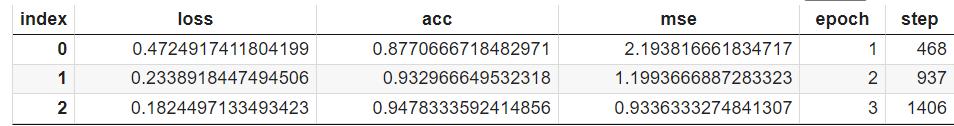

In [ ]:
history.groupby('epoch').last().drop('step', axis=1) 

,loss,acc,mse
epoch,,,
0,0.482410,0.878467,2.088800
1,0.239349,0.932083,1.208517
2,0.188345,0.946650,0.972150


### validation_step( )

```python 
## call triaining & validation process 
trainer.fit(model, trainDataLoader, valDataLoader)
## call validation process 
trainer.validate(model, valDataLoader)
```

```python 
## basic code : step level 
def validation_step(self, batch, batch_idx):
    x, y = batch
    y_hat = self(x)
    loss = F.cross_entropy(y_hat, y)
    self.log("val_loss", loss)
    return loss

## epoch level
def validation_step(self, batch, batch_idx):
    x, y = batch
    y_hat = self(x)
    loss = F.cross_entropy(y_hat, y)
#    pred = ...
    return pred

def validation_epoch_end(self, validation_step_outputs):
    all_preds = torch.stack(validation_step_outputs)
#    ...

## Display with PRogressBar 
def validation_step(self, batch, batch_idx):
    x, y = batch
    y_hat = self(x)
    loss = loss_function(y_hat, y)
    acc = FM.accuracy(y_hat, y)
    mse = FM.mean_squared_error(torch.argmax(y_hat, dim=1), y)
    metrics={'val_loss': loss, 'val_acc':acc, 'val_mse': mse}
    self.log_dict(metrics) #on_step=False, on_epoch=True
    return loss
```

In [ ]:
loss_function = nn.CrossEntropyLoss()
class MyModel(pl.LightningModule):
    def __init__(self):
        super(MyModel, self).__init__()
        self.layers =  Model()
    
    def forward(self, x):
        out = self.layers(x)
        return out
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x) 
        loss = loss_function(y_pred, y)
        acc = FM.accuracy(y_pred, y)
        mse = FM.mean_squared_error(torch.argmax(y_pred, dim=1), y)
        metrics={'loss': loss, 'acc':acc, 'mse': mse}
        self.log_dict(metrics,prog_bar=True)#on_step=True, on_epoch=False)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = loss_function(y_hat, y)
        acc = FM.accuracy(y_hat, y)
        mse = FM.mean_squared_error(torch.argmax(y_hat, dim=1), y)
        metrics={'val_loss': loss, 'val_acc':acc, 'val_mse': mse}
        self.log_dict(metrics) #on_step=False, on_epoch=True
#        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

model = MyModel()
summary(model, input_size=(8, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
MyModel                                  [8, 10]                   --
├─Model: 1-1                             [8, 10]                   --
│    └─Flatten: 2-1                      [8, 784]                  --
│    └─Linear: 2-2                       [8, 32]                   25,120
│    └─ReLU: 2-3                         [8, 32]                   --
│    └─Linear: 2-4                       [8, 32]                   25,120
│    └─ReLU: 2-5                         [8, 32]                   --
│    └─Linear: 2-6                       [8, 10]                   650
Total params: 50,890
Trainable params: 50,890
Non-trainable params: 0
Total mult-adds (M): 0.41
Input size (MB): 0.03
Forward/backward pass size (MB): 0.00
Params size (MB): 0.20
Estimated Total Size (MB): 0.23

In [ ]:
epochs=3
logger = pl.loggers.CSVLogger("logs", name="val_history_log")
trainer = pl.Trainer(max_epochs=epochs, logger=logger, accelerator='auto')
trainer.fit(model, trainDataLoader, valDataLoader) 

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name   | Type  | Params
---------------------------------
0 | layers | Model | 50.9 K
---------------------------------
50.9 K    Trainable params
0         Non-trainable params
50.9 K    Total params
0.204     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/progress/base.py:250: UserWarning: The progress bar already tracks a metric with the name(s) 'loss' and `self.log('loss', ..., prog_bar=True)` will overwrite this value.  If this is undesired, change the name or override `get_metrics()` in the progress bar callback.
  f"The progress bar already tracks a metric with the name(s) '{', '.join(duplicates)}' and"


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


In [ ]:
v_num = logger.version  
history = pd.read_csv(f'./logs/val_history_log/version_{v_num}/metrics.csv')
history  

,loss,acc,mse,epoch,step,val_loss,val_acc,val_mse
0,0.760328,0.835938,3.546875,0,49,NaN,NaN,NaN
1,0.468278,0.867188,2.515625,0,99,NaN,NaN,NaN
2,0.433054,0.890625,1.671875,0,149,NaN,NaN,NaN
3,0.368466,0.882812,2.570312,0,199,NaN,NaN,NaN
4,0.369251,0.875000,2.031250,0,249,NaN,NaN,NaN
5,0.322192,0.921875,0.835938,0,299,NaN,NaN,NaN
6,0.333426,0.882812,2.195312,0,349,NaN,NaN,NaN
7,0.234217,0.921875,1.382812,0,399,NaN,NaN,NaN
8,0.249272,0.937500,0.703125,0,449,NaN,NaN,NaN
9,NaN,NaN,NaN,0,468,0.264727,0.9244,1.2846


In [ ]:
trainer.validate(model,valDataLoader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.9550999999046326
        val_loss            0.1548876166343689
         val_mse            0.8597999811172485
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': 0.1548876166343689,
  'val_acc': 0.9550999999046326,
  'val_mse': 0.8597999811172485}]

In [ ]:
history.groupby('epoch').last().drop('step', axis=1)

,loss,acc,mse,val_loss,val_acc,val_mse
epoch,,,,,,
0,0.249272,0.937500,0.703125,0.264727,0.9244,1.2846
1,0.148061,0.953125,0.890625,0.194023,0.9452,1.0052
2,0.151758,0.953125,1.109375,0.154888,0.9551,0.8598


### test_step( )

In [ ]:
def test_step(self, batch, batch_idx):
    x, y = batch
    y_hat = self(x)
    loss = loss_function(y_hat, y)
    acc = FM.accuracy(y_hat, y)
    metrics={'test_loss': loss, 'test_acc':acc}
    self.log_dict(metrics) #on_step=False, on_epoch=True 

In [ ]:
loss_function = nn.CrossEntropyLoss()
class MyModel(pl.LightningModule):
    def __init__(self):
        super(MyModel, self).__init__()
        self.layers =  Model()
    
    def forward(self, x):
        out = self.layers(x)
        return out
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x) 
        loss = loss_function(y_pred, y)
        acc = FM.accuracy(y_pred, y)
        mse = FM.mean_squared_error(torch.argmax(y_pred, dim=1), y)
        metrics={'loss': loss, 'acc':acc, 'mse': mse}
        self.log_dict(metrics,prog_bar=True)#on_step=True, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = loss_function(y_hat, y)
        acc = FM.accuracy(y_hat, y)
        mse = FM.mean_squared_error(torch.argmax(y_hat, dim=1), y)
        metrics={'val_loss': loss, 'val_acc':acc, 'val_mse': mse}
        self.log_dict(metrics) #on_step=False, on_epoch=True

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = loss_function(y_hat, y)
        acc = FM.accuracy(y_hat, y)
        metrics={'test_loss': loss, 'test_acc':acc}
        self.log_dict(metrics)  
        
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

model = MyModel()
#summary(model, input_size=(8, 1, 28, 28))

epochs=3
trainer = pl.Trainer(max_epochs=epochs, accelerator='auto')
trainer.fit(model, trainDataLoader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/configuration_validator.py:110: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  category=PossibleUserWarning,
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name   | Type  | Params
---------------------------------
0 | layers | Model | 50.9 K
---------------------------------
50.9 K    Trainable params
0         Non-trainable params
50.9 K    Total params
0.204     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/progress/base.py:250: UserWarning: The progress bar already tracks a metric with the name(s) 'loss' and `self.log('loss', ..., prog_bar=True)` will overwrite this value.  If this is undesired, change the name or override `get_metrics()` in the progress bar callback.
  f"The progress bar already tracks a metric with the name(s) '{', '.join(duplicates)}' and"
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


In [ ]:
trainer.validate(model, valDataLoader) 
trainer.test(model, valDataLoader) 

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.9508000016212463
        val_loss            0.16573451459407806
         val_mse            0.9412999749183655
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9508000016212463
        test_loss           0.16573451459407806
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.16573451459407806, 'test_acc': 0.9508000016212463}]

### predict_step( )

**forward( )를 overide하여 학습된 모델을 실행하는 별도의 process를 생성 가능** 

In [ ]:
loss_function = nn.CrossEntropyLoss()

class MyModel(pl.LightningModule):
    def __init__(self):
        super(MyModel, self).__init__()
        self.layers =  Model()
    
    def forward(self, x):
        out = self.layers(x)
        return out
    
    def predict_step(self, x, batch_idx):
        y_pred = self(x) 
        y_pb = nn.Softmax(y_pred)
        return y_pb

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x) 
        loss = loss_function(y_pred, y)
        acc = FM.accuracy(y_pred, y)
        mse = FM.mean_squared_error(torch.argmax(y_pred, dim=1), y)
        metrics={'loss': loss, 'acc':acc, 'mse': mse}
        self.log_dict(metrics,prog_bar=True)#on_step=True, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = loss_function(y_hat, y)
        acc = FM.accuracy(y_hat, y)
        mse = FM.mean_squared_error(torch.argmax(y_hat, dim=1), y)
        metrics={'val_loss': loss, 'val_acc':acc, 'val_mse': mse}
        self.log_dict(metrics) #on_step=False, on_epoch=True
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

model = MyModel()
#summary(model, input_size=(8, 1, 28, 28))

epochs=3
trainer = pl.Trainer(max_epochs=epochs, accelerator='auto')
trainer.fit(model, trainDataLoader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/configuration_validator.py:110: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  category=PossibleUserWarning,
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name   | Type  | Params
---------------------------------
0 | layers | Model | 50.9 K
---------------------------------
50.9 K    Trainable params
0         Non-trainable params
50.9 K    Total params
0.204     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/progress/base.py:250: UserWarning: The progress bar already tracks a metric with the name(s) 'loss' and `self.log('loss', ..., prog_bar=True)` will overwrite this value.  If this is undesired, change the name or override `get_metrics()` in the progress bar callback.
  f"The progress bar already tracks a metric with the name(s) '{', '.join(duplicates)}' and"
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


In [ ]:
batch = next(iter(valDataLoader)) # ((128,1,28,28),(128,1))
y_predict = model(batch[0])       # model <- image only 
p(y_predict,'\n')                 # (128,10) 

Shape:torch.Size([128, 10])
Type: <class 'torch.Tensor'>
Values: tensor([[ -1.4223,  -8.0898,   0.2841,  ...,   7.7657,  -1.7524,   0.5528],
        [  0.8240,   0.7654,   9.4985,  ..., -11.9669,   1.3504, -16.2926],
        [ -5.0422,   5.4905,  -0.2107,  ...,  -0.0278,  -0.6560,  -3.9119],
        ...,
        [ -6.1814,  -2.1096,  -0.2870,  ...,  -1.7966,   0.2470,   3.2074],
        [  4.1566,  -5.0211,   0.7001,  ...,  -2.3681,  -1.7997,   0.0690],
        [ -2.8233,  -6.0476,  -5.9544,  ...,  -8.6088,   0.3654,  -5.2105]],
       grad_fn=<AddmmBackward0>)



In [ ]:
batch = next(iter(valDataLoader)) # ((128,1,28,28),(128,10))
# forward()실행
y_predict = model(batch[0])       # model <- image only 
p(y_predict[0],'logit')           # 첫image에 대한 출력(logit) 
# predict_step()실행 
y_predict = trainer.predict(model, batch[0]) # model <- image only 
p(y_predict[0],'prob.')           #  첫image에 대한 출력(prob.)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


<<logit>>:
Shape:torch.Size([10])
Type: <class 'torch.Tensor'>
Values: tensor([ -1.1683,  -8.1295,   0.4711,   3.2466,  -5.3961,  -1.5265, -11.3048,
          9.0238,  -1.6659,   0.5325], grad_fn=<SelectBackward0>)


Predicting: 469it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loops/epoch/prediction_epoch_loop.py:173: UserWarning: Lightning couldn't infer the indices fetched for your dataloader.
  warning_cache.warn("Lightning couldn't infer the indices fetched for your dataloader.")


<<prob.>>:
Type: <class 'torch.nn.modules.activation.Softmax'>
Values: Softmax(
  dim=tensor([[ -1.1683,  -8.1295,   0.4711,   3.2466,  -5.3961,  -1.5265, -11.3048,
             9.0238,  -1.6659,   0.5325]], device='cuda:0')
)


```python
class LitMCdropoutModel(pl.LightningModule):
    def __init__(self, model, mc_iteration):
        super().__init__()
        self.model = model
        self.dropout = nn.Dropout()
        self.mc_iteration = mc_iteration

    def predict_step(self, batch, batch_idx):
        # enable Monte Carlo Dropout
        self.dropout.train() ## train flag
        # take average of `self.mc_iteration` iterations # torch.unsqueeze(0):(new_axis,...) 
        pred = torch.vstack([self.dropout(self.model(x)).unsqueeze(0) for _ in range(self.mc_iteration)]).mean(dim=0)
        return pred
```        

## Inference / Prediction

In [ ]:
batch = next(iter(valDataLoader)) # ((128,1,28,28),(128,10))
## Sets the module in evaluation mode.(Dropout,BN,..)
model.eval() 
y_predict = model(batch[0])       # model <- image only 
p(y_predict,'\n')                 # (128,10) 
p(y_predict[0,:],'\n')            # (10,) 
p(y_predict[0,:].detach(),'\n')   # (10,) w/o grad_fn
p(np.argmax(y_predict[0,:].detach()).numpy(),'np') # index      
p(np.argmax(y_predict[0,:].detach()),'tensor') # index tensor     
#p(np.argmax(y_predict[0,:])) ## Error: Can't call numpy() on Tensor that requires grad.

Shape:torch.Size([128, 10])
Type: <class 'torch.Tensor'>
Values: tensor([[ -1.4223,  -8.0898,   0.2841,  ...,   7.7657,  -1.7524,   0.5528],
        [  0.8240,   0.7654,   9.4985,  ..., -11.9669,   1.3504, -16.2926],
        [ -5.0422,   5.4905,  -0.2107,  ...,  -0.0278,  -0.6560,  -3.9119],
        ...,
        [ -6.1814,  -2.1096,  -0.2870,  ...,  -1.7966,   0.2470,   3.2074],
        [  4.1566,  -5.0211,   0.7001,  ...,  -2.3681,  -1.7997,   0.0690],
        [ -2.8233,  -6.0476,  -5.9544,  ...,  -8.6088,   0.3654,  -5.2105]],
       grad_fn=<AddmmBackward0>)

Shape:torch.Size([10])
Type: <class 'torch.Tensor'>
Values: tensor([ -1.4223,  -8.0898,   0.2841,   3.0873,  -6.3615,  -1.4295, -10.3944,
          7.7657,  -1.7524,   0.5528], grad_fn=<SliceBackward0>)

Shape:torch.Size([10])
Type: <class 'torch.Tensor'>
Values: tensor([ -1.4223,  -8.0898,   0.2841,   3.0873,  -6.3615,  -1.4295, -10.3944,
          7.7657,  -1.7524,   0.5528])

<<np>>:
Shape:()
Type: <class 'numpy.ndarray'>
Va

In [ ]:
batch = next(iter(valDataLoader)) # ((128,1,28,28),(128,10))
## Sets the module in evaluation mode.(Dropout,BN,..)
model.eval() 

## disabled gradient calculation.(reduce memory)
with torch.no_grad():             ### w/o grad_fn object ###
    y_predict = model(batch[0])   # model <- image only 

p(y_predict,'\n')                 # (128,10) tensor, w/o grad_fn
p(y_predict[0,:],'\n')            # (10,)    tensor, w/o grad_fn  
p(np.argmax(y_predict[0,:].numpy()),'np') # numpy index      
p(np.argmax(y_predict[0,:]),'tensor') # tensor index     

Shape:torch.Size([128, 10])
Type: <class 'torch.Tensor'>
Values: tensor([[ -1.4223,  -8.0898,   0.2841,  ...,   7.7657,  -1.7524,   0.5528],
        [  0.8240,   0.7654,   9.4985,  ..., -11.9669,   1.3504, -16.2926],
        [ -5.0422,   5.4905,  -0.2107,  ...,  -0.0278,  -0.6560,  -3.9119],
        ...,
        [ -6.1814,  -2.1096,  -0.2870,  ...,  -1.7966,   0.2470,   3.2074],
        [  4.1566,  -5.0211,   0.7001,  ...,  -2.3681,  -1.7997,   0.0690],
        [ -2.8233,  -6.0476,  -5.9544,  ...,  -8.6088,   0.3654,  -5.2105]])

Shape:torch.Size([10])
Type: <class 'torch.Tensor'>
Values: tensor([ -1.4223,  -8.0898,   0.2841,   3.0873,  -6.3615,  -1.4295, -10.3944,
          7.7657,  -1.7524,   0.5528])

<<np>>:
Shape:()
Type: <class 'numpy.int64'>
Values: 7
<<tensor>>:
Shape:torch.Size([])
Type: <class 'torch.Tensor'>
Values: 7


In [ ]:
p(np.argmax(model(batch[0]).detach(),axis=1).numpy(),'ndarray') 
p(batch[1],'Tensor')

<<ndarray>>:
Shape:(128,)
Type: <class 'numpy.ndarray'>
Values: [7 2 1 0 4 1 4 9 6 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1 3 1 3 6 7 2 7
 1 2 1 1 7 4 2 3 5 1 2 4 4 6 3 5 5 6 0 4 1 9 5 7 8 9 3 7 4 6 4 3 0 7 0 2 9
 1 7 3 2 9 7 7 6 2 7 8 4 7 3 6 1 3 6 9 3 1 4 1 7 6 9 6 0 5 4 9 9 2 1 9 4 8
 7 3 9 7 4 4 4 9 2 5 4 7 6 7 9 0 5]
<<Tensor>>:
Shape:torch.Size([128])
Type: <class 'torch.Tensor'>
Values: tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2,
        4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3, 7, 4, 6, 4, 3, 0, 7, 0,
        2, 9, 1, 7, 3, 2, 9, 7, 7, 6, 2, 7, 8, 4, 7, 3, 6, 1, 3, 6, 9, 3, 1, 4,
        1, 7, 6, 9, 6, 0, 5, 4, 9, 9, 2, 1, 9, 4, 8, 7, 3, 9, 7, 4, 4, 4, 9, 2,
        5, 4, 7, 6, 7, 9, 0, 5])


**rank, shape, axis**

In [ ]:
## rank, shape, axis 
d = np.zeros((2,3,4)) 
print(d.ndim)  
p(d)
# #of_rank = 3
# shape=(2,3,4), 
# axis:(0,1,2) or (0,1,-1) 
#     (z, y, x)

3
<<>>:
Shape:(2, 3, 4)
Type: <class 'numpy.ndarray'>
Values: [[[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]]
